# Experimentos de optimización: $f(x,y)=y^2 + \log(1+x^2)$

**Autor:** Alina María de la Noval Armenteros  
**Grupo:** C-311  


**Objetivo:** Aplicar los métodos Descenso por Gradiente con Armijo y BFGS (Cuasi-Newton) a la función $f(x,y)=y^2 + \log(1+x^2)$, comparar su comportamiento en términos de convergencia, número de iteraciones, tiempo y sensibilidad al punto inicial, y documentar conclusiones técnicas.

**Resumen breve:** Esta función combina un término cuadrático en $y$ con un término logarítmico en $x$; la diferencia en curvatura entre las direcciones $x$ y $y$ la hace adecuada para comparar la eficacia de métodos de primer y segundo orden.

## Descripción teórica del problema

Función objetivo: $$f(x,y)=y^2 + \log(1+x^2).$$

- Dominio: definida para todo $(x,y)\in\mathbb{R}^2$ ya que $1+x^2>0$ para todo $x$.
- Descomposición: la función se puede escribir como suma de funciones univariadas, $f(x,y)=g(x)+h(y)$ con $g(x)=\log(1+x^2)$ y $h(y)=y^2$. Esto facilita el análisis teórico y numérico.
- Regularidad: ambas componentes son $C^{\infty}$ en el dominio, por lo que $f\in C^{\infty}(\mathbb{R}^2)$; es válido usar métodos que requieran gradiente y aproximaciones de la Hessiana.

**Gradiente:**
$$\nabla f(x,y)=\begin{pmatrix}\dfrac{2x}{1+x^2}\\2y\end{pmatrix}.$$

**Hessiano:**
$$\nabla^2 f(x,y)=\begin{pmatrix}\dfrac{2(1-x^2)}{(1+x^2)^2} & 0\\0 & 2\end{pmatrix}.$$

- Observación sobre convexidad: la componente $(2(1-x^2)/(1+x^2)^2)$ cambia de signo: es positiva para $|x|<1$, cero en $|x|=1$ y negativa para $|x|>1$. Por tanto, el Hessiano no es globalmente semidefinido positivo y la función no es convexa globalmente; sin embargo, localmente alrededor del origen muestra comportamiento convexo.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from optimizacion import gradient_descent_armijo, bfgs
from optimizacion.line_search import backtracking_armijo
from optimizacion.util_json import run_and_save_experiments, load_experiments_from_json
from optimizacion.graficos import plot_convergence, plot_final_vs_iters, plot_trajectory_2d
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(0)

In [2]:
import numpy as np

def f(x):
    """Función objetivo. `x` es array-like [x, y].
    Devuelve escalar f(x).
    """
    x = np.asarray(x)
    xv = float(x[0])
    yv = float(x[1])
    return yv**2 + np.log(1.0 + xv**2)

def grad(x):
    """Gradiente de f: devuelve array [df/dx, df/dy].
    """
    x = np.asarray(x)
    xv = float(x[0])
    yv = float(x[1])
    dfdx = (2.0 * xv) / (1.0 + xv**2)
    dfdy = 2.0 * yv
    return np.array([dfdx, dfdy])



In [ ]:
algorithms = ['gd', 'bfgs']  
points = [np.array([2.0, 1.5]), np.array([0.9,0.0]), np.array([2.5,0.0]), np.array([0.0,2.5]), np.array([-3.0,1.5]), np.array([5.0,-2.0])]

tolerance = 1e-6
maxiter = 500

run_configs = []
for alg in algorithms:
    for x0 in points:
        cfg = {
            'algorithm': alg,
            'x0': x0,
            'tolerance': tolerance,
            'line_search': backtracking_armijo if alg == 'gd' else None,
            'maxiter': maxiter
        }
        run_configs.append(cfg)

In [10]:
# Mapear nombres a funciones (coincide con 'algorithm' en run_configs)
algorithm_fn_map = {
    'gd': gradient_descent_armijo,
    'bfgs': bfgs
}

# Ejecutar y guardar resultados (guardará en data/resultados/experimentos.json)
output_file = 'data/resultados/experimentos.json'
experiment_data = run_and_save_experiments(run_configs, algorithm_fn_map, filename=output_file, f=f, grad=grad)



[Exp 1] algoritmo=gd x0=[2.0, 1.5] tol=1e-06 ls=<function backtracking_armijo at 0x000002D9F0A8CAE0>

[Exp 2] algoritmo=gd x0=[0.9, 0.0] tol=1e-06 ls=<function backtracking_armijo at 0x000002D9F0A8CAE0>

[Exp 3] algoritmo=gd x0=[2.5, 0.0] tol=1e-06 ls=<function backtracking_armijo at 0x000002D9F0A8CAE0>

[Exp 4] algoritmo=gd x0=[0.0, 2.5] tol=1e-06 ls=<function backtracking_armijo at 0x000002D9F0A8CAE0>

[Exp 5] algoritmo=gd x0=[-3.0, 1.5] tol=1e-06 ls=<function backtracking_armijo at 0x000002D9F0A8CAE0>

[Exp 6] algoritmo=gd x0=[5.0, -2.0] tol=1e-06 ls=<function backtracking_armijo at 0x000002D9F0A8CAE0>

[Exp 7] algoritmo=bfgs x0=[2.0, 1.5] tol=1e-06 ls=None

[Exp 8] algoritmo=bfgs x0=[0.9, 0.0] tol=1e-06 ls=None

[Exp 9] algoritmo=bfgs x0=[2.5, 0.0] tol=1e-06 ls=None

[Exp 10] algoritmo=bfgs x0=[0.0, 2.5] tol=1e-06 ls=None

[Exp 11] algoritmo=bfgs x0=[-3.0, 1.5] tol=1e-06 ls=None

[Exp 12] algoritmo=bfgs x0=[5.0, -2.0] tol=1e-06 ls=None
Resultados guardados en: data/resultados/expe

In [11]:
# Cargar resultados desde JSON para análisis/plotting
data = load_experiments_from_json('data/resultados/experimentos.json')
experiments = data.get('experiments', [])

Cargado: data/resultados/experimentos.json
  Metadatos: ['timestamp', 'schema_version', 'python_version', 'numpy_version', 'scipy_version', 'matplotlib_version', 'objective_function', 'algorithms', 'author']
  Número de experimentos: 12


Gráfica guardada: data/resultados/convergencia_gd.png


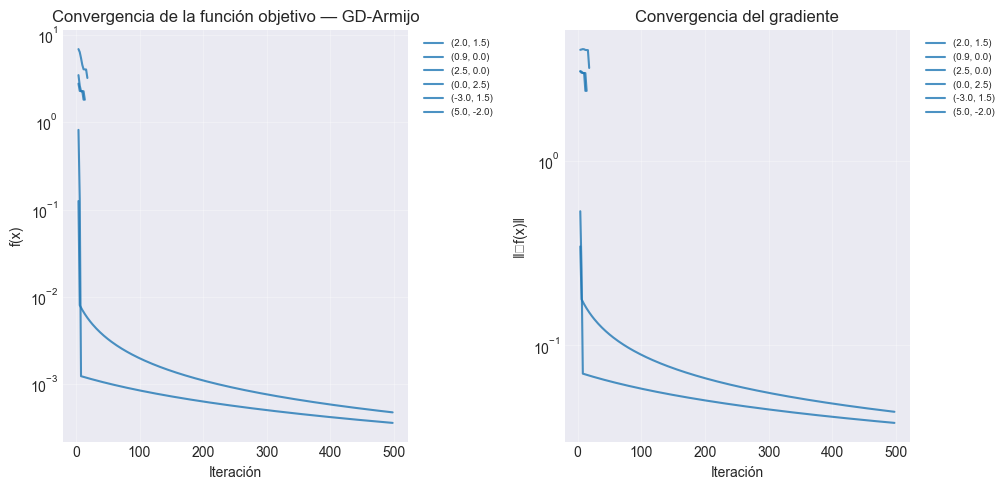

Gráfica guardada: data/resultados/convergencia_bfgs.png


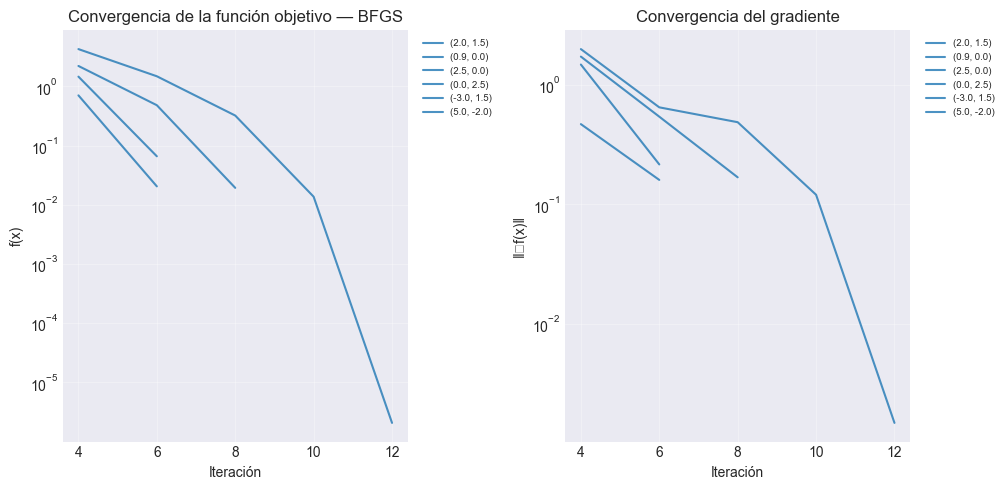

Gráfica guardada: data/resultados/final_vs_iters_gd.png


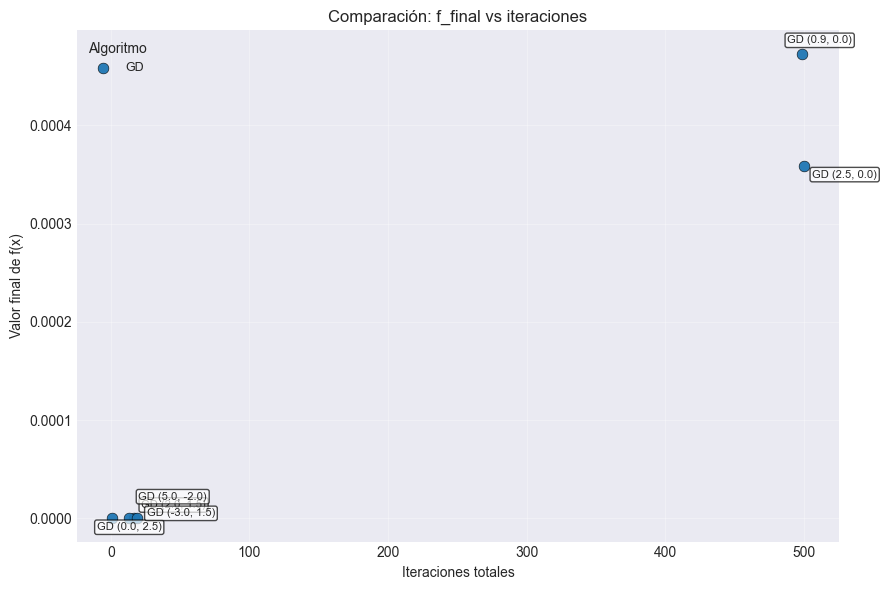

Gráfica guardada: data/resultados/final_vs_iters_bfgs.png


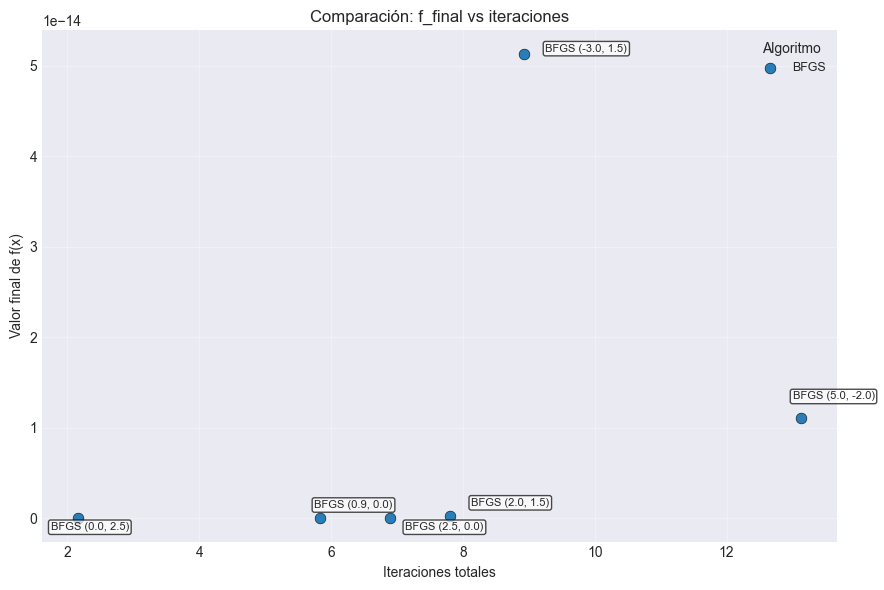

Gráfica guardada: data/resultados/trayectoria_exp1.png


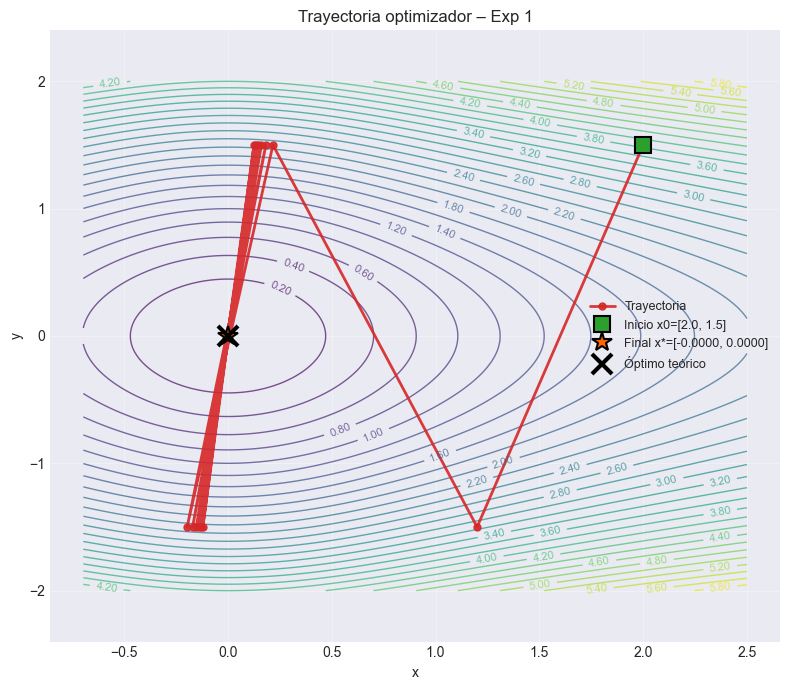

In [12]:
# Graficación: convergencia, comparación y trayectorias individuales
import os
os.makedirs('data/resultados', exist_ok=True)
plot_convergence(experiments, filename='data/resultados/convergencia.png', group_by='algorithm', smooth_window=5, decimate=2, legend_outside=True, legend_fontsize='x-small', compact_labels=True)
plot_final_vs_iters(experiments, filename='data/resultados/final_vs_iters.png', group_by='algorithm')
if experiments:
    exp0 = experiments[0]
    plot_trajectory_2d(exp0, filename='data/resultados/trayectoria_exp1.png')